In [28]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [29]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import os
import tensorflow as tf
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.optimizers import RMSprop
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau

# Labelling Data

- No ship = 0
- Ship = 1

In [30]:
label_number = {'No_ship' : 0, 'Ship' : 1}
label_word = ['No_ship', 'Ship']

[](http://)

In [31]:
dataframed = pd.DataFrame(columns = ['path', 'label', 'scene_id', 'longitude', 'latitude'])
scenes = pd.DataFrame(columns = ['path', 'label'])

In [32]:
dataframes = [dataframed]
for x in range(0, len(dataframes)):
    temp = 'archive\shipsnet\shipsnet'
    for dirname, _, filenames in os.walk(temp) :
            for filename in filenames :
                path = os.path.join(dirname, filename)
                name = filename
                splitter = name.split('_')
                path = os.path.join(dirname, filename)
                label = int(splitter[0])
                scene_id = splitter[2] + '_' + splitter[3] + '_' + splitter[4]
                longitude = splitter[6]
                latitude = splitter[7].rstrip('.png')
                dataframes[x].loc[len(dataframes[x])] = [temp + '/' + name, label, scene_id, longitude, latitude]

In [33]:
dataframes = [scenes]
for x in range(0, len(dataframes)):
    temp = 'archive\scenes\scenes'
    for dirname, _, filenames in os.walk(temp) :
            for filename in filenames :
                path = os.path.join(dirname, filename)
                name = filename
                path = os.path.join(dirname, filename)
                dataframes[x].loc[len(dataframes[x])] = [temp + '/' + name, filename]

In [34]:
dataframed.head()

path  label  \
0  archive\shipsnet\shipsnet/0__20150718_184300_0...      0   
1  archive\shipsnet\shipsnet/0__20150718_184300_0...      0   
2  archive\shipsnet\shipsnet/0__20150718_184300_0...      0   
3  archive\shipsnet\shipsnet/0__20150718_184300_0...      0   
4  archive\shipsnet\shipsnet/0__20150720_184302_0...      0   

               scene_id            longitude            latitude  
0  20150718_184300_090b  -122.35324421973536  37.772113980272394  
1  20150718_184300_090b  -122.38458613431831  37.763521076612484  
2  20150718_184300_090b  -122.40477488428849    37.8071040053892  
3  20150718_184300_090b  -122.42663861582857   37.80913223576201  
4  20150720_184302_0906  -122.21893759782994   37.87172273326103

# Dataset consists of :

- **8 Scenes = 4000 images**

In [35]:
print("Shape of the Dataset =", dataframed.shape)

Shape of the Dataset = (4000, 5)


# Sample Images : Scenes (8 Samples)

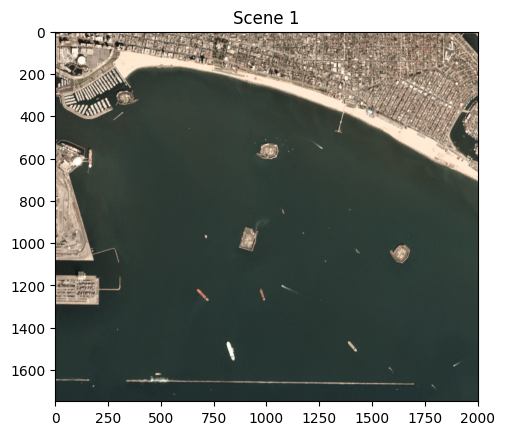

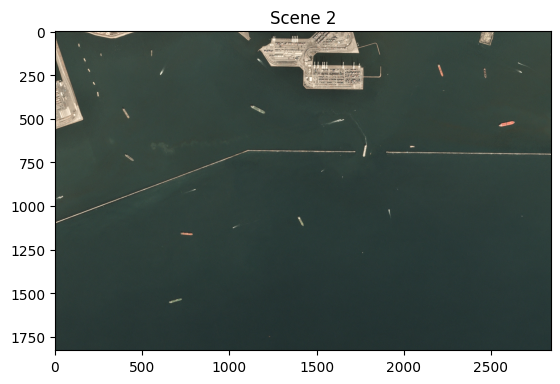

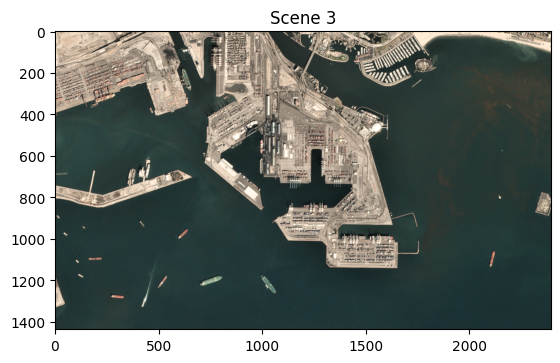

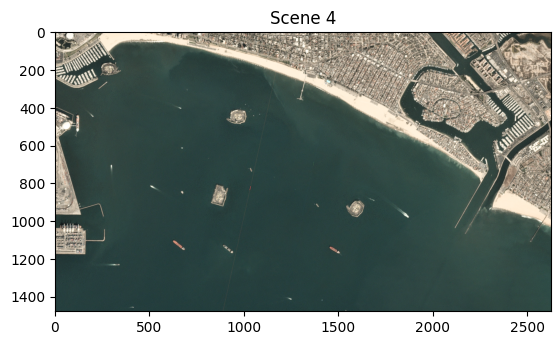

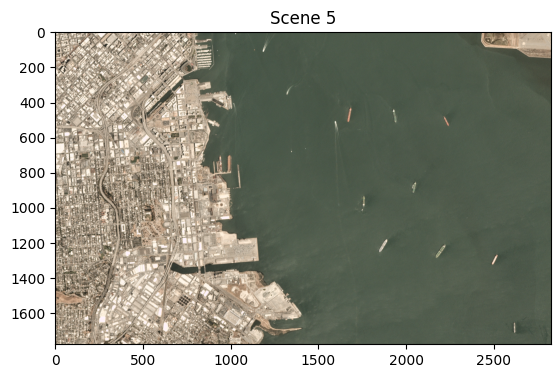

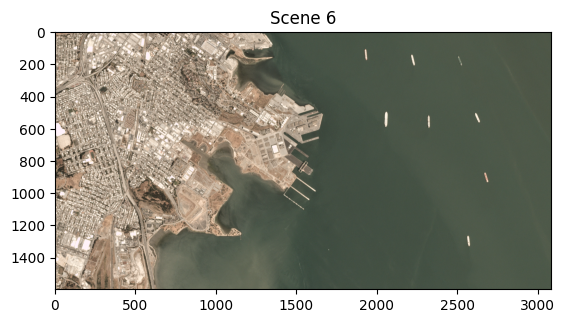

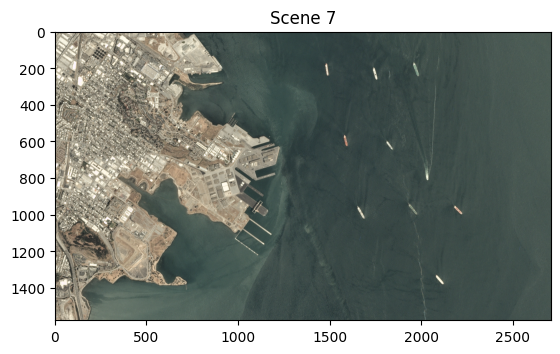

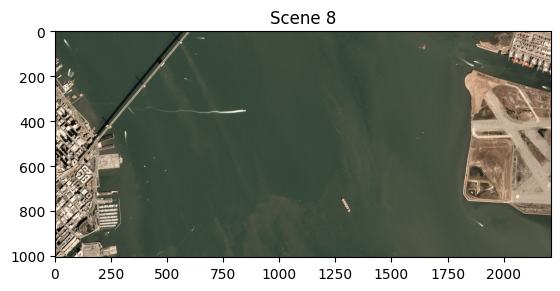

In [36]:
import matplotlib.image as mpimg

for x in range(0, 8) :
        img = mpimg.imread(scenes.iloc[int(x)]['path'])
        plt.subplots()
        plt.imshow(img)
        plt.title("Scene " + str(x + 1))

# Sample Images : No ships (10 Samples)

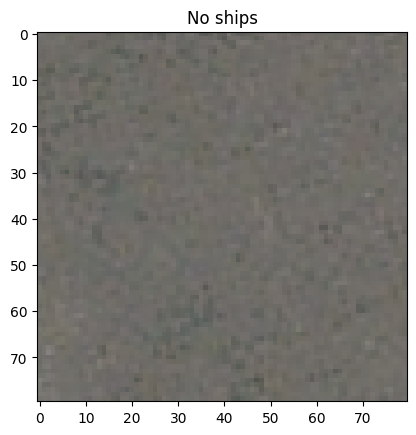

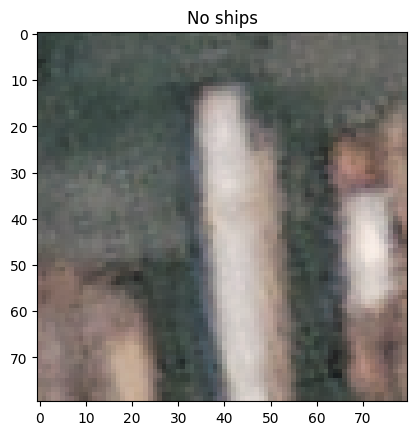

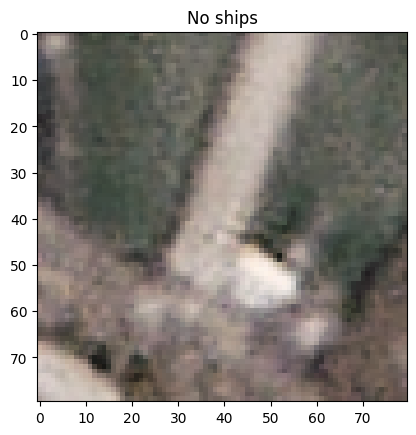

In [61]:
import matplotlib.image as mpimg
listed = list(np.where(dataframed["label"] == 0))
listed = listed[0].tolist()
for x in range(0, 3) :
        img = mpimg.imread(dataframed.iloc[int(listed[x])]['path'])
        plt.subplots()
        plt.imshow(img)
        plt.title("No ships")

# Sample Images : Ships (10 Samples)

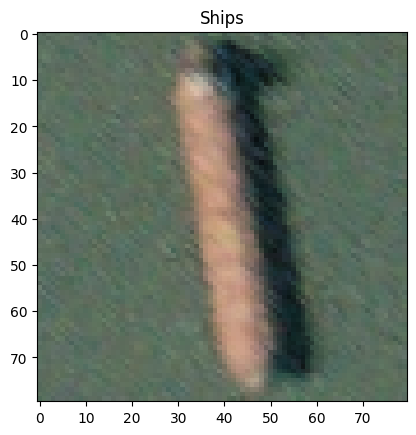

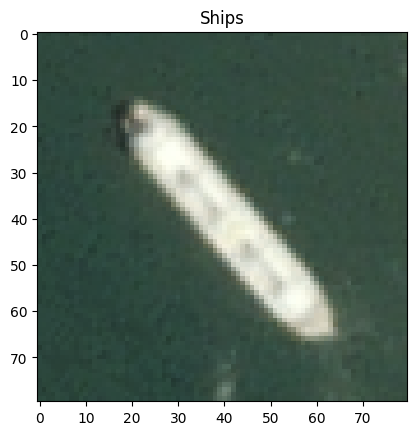

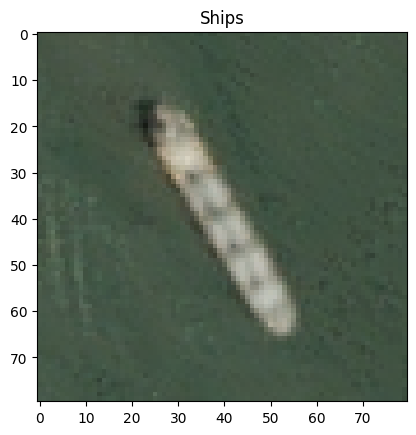

In [62]:
import matplotlib.image as mpimg
listed = list(np.where(dataframed["label"] == 1))
listed = listed[0].tolist()
for x in range(0, 3) :
        img = mpimg.imread(dataframed.iloc[int(listed[x])]['path'])
        plt.subplots()
        plt.imshow(img)
        plt.title("Ships")

# Split The Data for Training and Testing Purposes

**Test Sizes**

- 20%

In [39]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframed, test_size=0.2, random_state = 42)

# Contents of Training Data

In [40]:
train.head()

path  label  \
3994  archive\shipsnet\shipsnet/1__20180714_180352_1...      1   
423   archive\shipsnet\shipsnet/0__20170129_181028_0...      0   
2991  archive\shipsnet\shipsnet/0__20180714_180427_1...      0   
1221  archive\shipsnet\shipsnet/0__20170620_232624_0...      0   
506   archive\shipsnet\shipsnet/0__20170314_155238_0...      0   

                  scene_id            longitude            latitude  
3994  20180714_180352_100e   -118.1308190306784   33.68929275663629  
423   20170129_181028_0e1f  -122.41265418292006   37.66402317534539  
2991  20180714_180427_1029  -118.45370965127138   33.75160406361845  
1221  20170620_232624_0c79  -122.34177102204659    37.7291118869442  
506   20170314_155238_0c12  -122.32983736420354  37.719797138747296

# Contents of Testing Data

In [41]:
test.head()

path  label  \
555   archive\shipsnet\shipsnet/0__20170403_180411_1...      0   
3491  archive\shipsnet\shipsnet/1__20170723_180811_1...      1   
527   archive\shipsnet\shipsnet/0__20170314_155240_0...      0   
3925  archive\shipsnet\shipsnet/1__20180711_182156_1...      1   
2989  archive\shipsnet\shipsnet/0__20180714_180427_1...      0   

                  scene_id            longitude            latitude  
555   20170403_180411_100f  -122.21240105336439   37.73256368566546  
3491  20170723_180811_1005  -122.33460459318182  37.757652320523135  
527   20170314_155240_0c12  -122.27084038989882   37.76552202417028  
3925  20180711_182156_1048  -122.33297269876117  37.726980389905535  
2989  20180714_180427_1029  -118.21031495796909   33.73120640938179

# Preprocessing Image Data

In [44]:
import cv2
import numpy as np
import pandas as pd

def size_regulator(df, image_column='path', target_size=(80, 80)):
    fft_images = []  # This will store the FFT images
    for path in df[image_column]:
        # Read the image in grayscale
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # Resize the image
        image = cv2.resize(image, target_size)
        # Apply FFT
        f_transform = np.fft.fft2(image)
        f_shift = np.fft.fftshift(f_transform)
        # Compute magnitude spectrum
        magnitude_spectrum = 20 * np.log(np.abs(f_shift))
        fft_images.append(magnitude_spectrum)
    return np.array(fft_images)

In [45]:
X_Train = size_regulator(train)
X_Test = size_regulator(test)

In [46]:
y_Train = train
y_Test = test

In [47]:
y_Train = y_Train.drop(['path', 'scene_id', 'longitude', 'latitude'], axis=1)
y_Test = y_Test.drop(['path', 'scene_id', 'longitude', 'latitude'], axis=1)

In [48]:
y_Train.head()

label
3994      1
423       0
2991      0
1221      0
506       0

In [49]:
y_Train_encoded = to_categorical(y_Train)

In [50]:
y_Test.head()

label
555       0
3491      1
527       0
3925      1
2989      0

In [51]:
y_Test_encoded = to_categorical(y_Test)

In [52]:
y_Train_encoded = np.asarray(y_Train_encoded).astype('float32').reshape((-1,1))
y_Test_encoded = np.asarray(y_Test_encoded).astype('float32').reshape((-1,1))


In [53]:
X_Train = X_Train.reshape(-1, 80, 80, 1)
y_Train = np.array(y_Train)


X_Test = X_Test.reshape(-1, 80, 80, 1)
y_Test_np = np.array(y_Test)

In [54]:
print("images in Train Shape = ", X_Train.shape)
print("images in Test Shape = " , X_Test.shape)

images in Train Shape =  (3200, 80, 80, 1)
images in Test Shape =  (800, 80, 80, 1)


In [55]:
Boat_Detection = Sequential()

Boat_Detection.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (80,80,1)))
Boat_Detection.add(BatchNormalization())
Boat_Detection.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Boat_Detection.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
Boat_Detection.add(Dropout(0.1))
Boat_Detection.add(BatchNormalization())
Boat_Detection.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Boat_Detection.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
Boat_Detection.add(BatchNormalization())
Boat_Detection.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Boat_Detection.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
Boat_Detection.add(Dropout(0.2))
Boat_Detection.add(BatchNormalization())
Boat_Detection.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Boat_Detection.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
Boat_Detection.add(Dropout(0.2))
Boat_Detection.add(BatchNormalization())
Boat_Detection.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
Boat_Detection.add(Flatten())
Boat_Detection.add(Dense(units = 128 , activation = 'relu'))
Boat_Detection.add(Dropout(0.2))
Boat_Detection.add(Dense(units = 1 , activation = 'sigmoid'))

In [56]:
Boat_Detection.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [57]:
learning_rate_callback = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [58]:
history = Boat_Detection.fit(X_Train, y_Train, batch_size = 32, epochs = 12)

Epoch 1/12
100/100 [==============================] - 7s 40ms/step - loss: 0.7511 - accuracy: 0.7125
Epoch 2/12
100/100 [==============================] - 4s 38ms/step - loss: 0.5898 - accuracy: 0.7450
Epoch 3/12
100/100 [==============================] - 4s 38ms/step - loss: 0.5902 - accuracy: 0.7450
Epoch 4/12
100/100 [==============================] - 4s 38ms/step - loss: 0.5874 - accuracy: 0.7450
Epoch 5/12
100/100 [==============================] - 4s 37ms/step - loss: 0.5799 - accuracy: 0.7450
Epoch 6/12
100/100 [==============================] - 4s 38ms/step - loss: 0.5773 - accuracy: 0.7450
Epoch 7/12
100/100 [==============================] - 4s 38ms/step - loss: 0.5805 - accuracy: 0.7450
Epoch 8/12
100/100 [==============================] - 4s 38ms/step - loss: 0.5794 - accuracy: 0.7450
Epoch 9/12
100/100 [==============================] - 4s 39ms/step - loss: 0.5770 - accuracy: 0.7450
Epoch 10/12
100/100 [==============================] - 4s 38ms/step - loss: 0.5719 - accura

# Loss and Accuracy Metrics

In [59]:
print("Loss of the model is - " , Boat_Detection.evaluate(X_Test,y_Test)[0])
print("Accuracy of the model is - " , Boat_Detection.evaluate(X_Test,y_Test)[1]*100 , "%")

25/25 [==============================] - 0s 10ms/step - loss: 4.9785 - accuracy: 0.2300
Loss of the model is -  4.978538513183594
25/25 [==============================] - 0s 9ms/step - loss: 4.9785 - accuracy: 0.2300
Accuracy of the model is -  23.000000417232513 %


# Testing Dataset Predictions

25/25 [==============================] - 0s 8ms/step


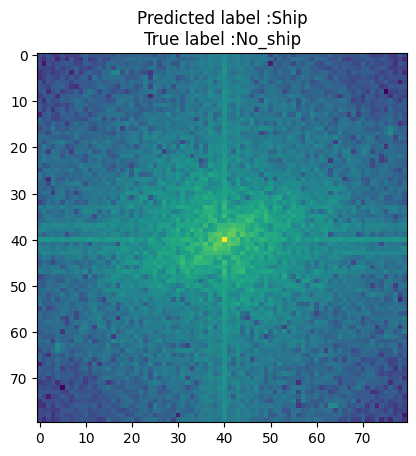

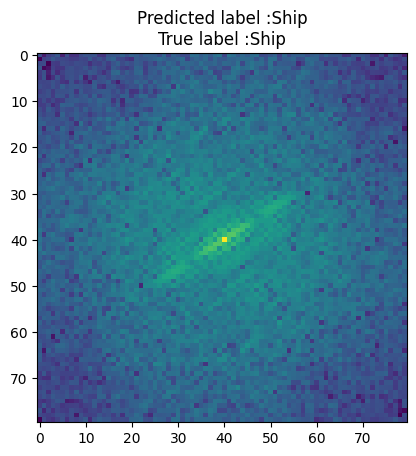

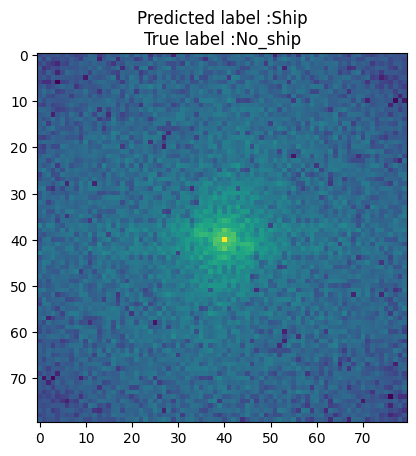

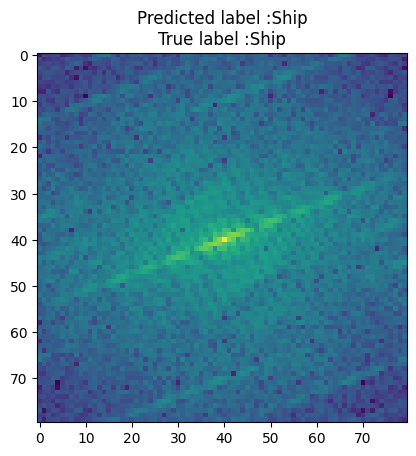

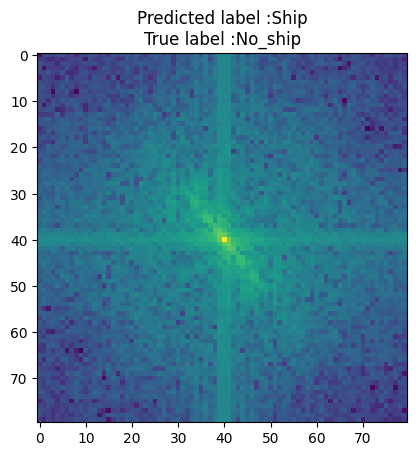

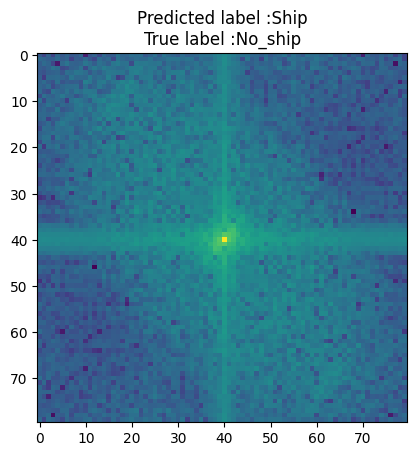

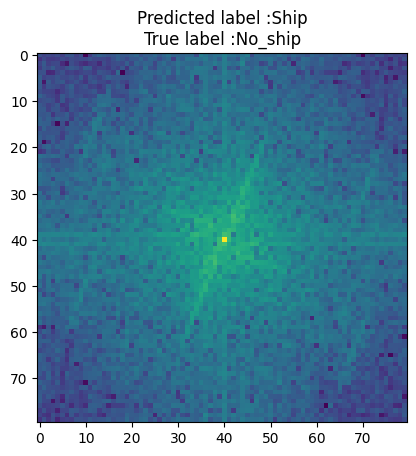

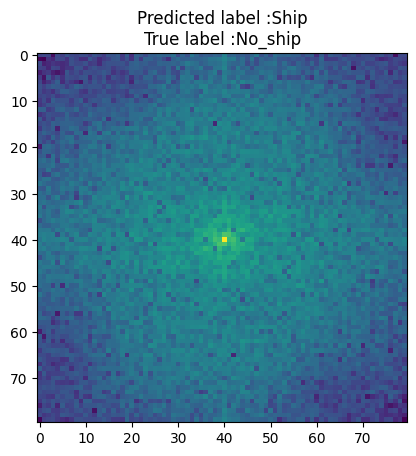

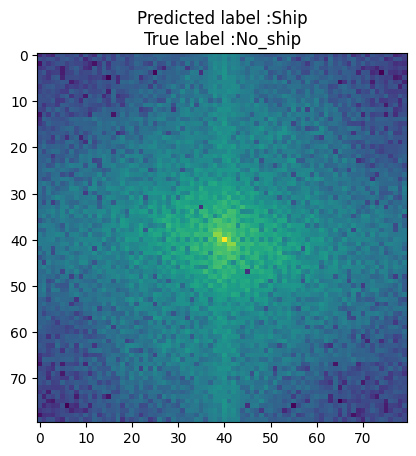

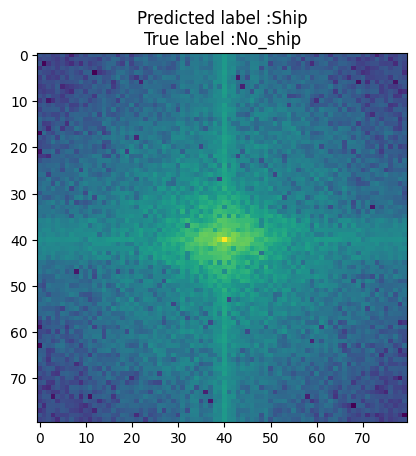

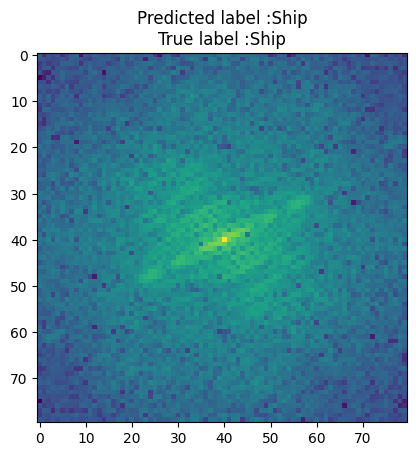

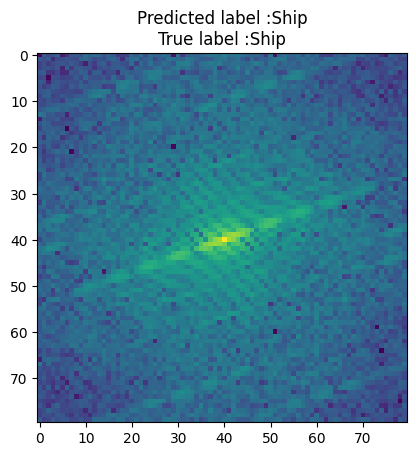

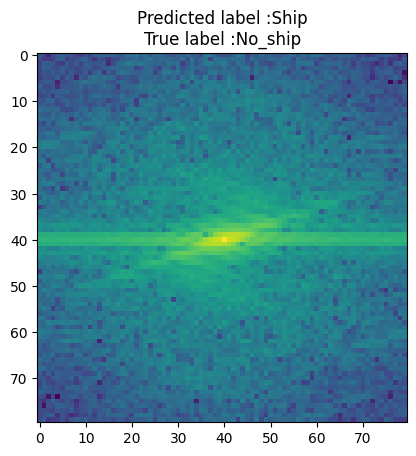

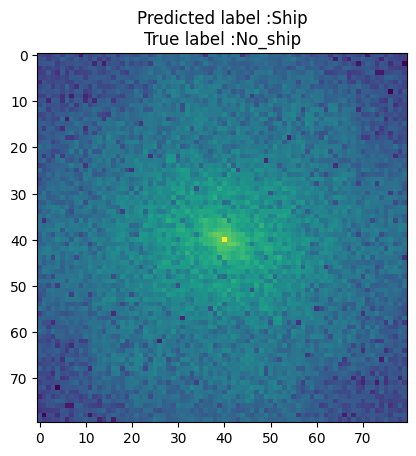

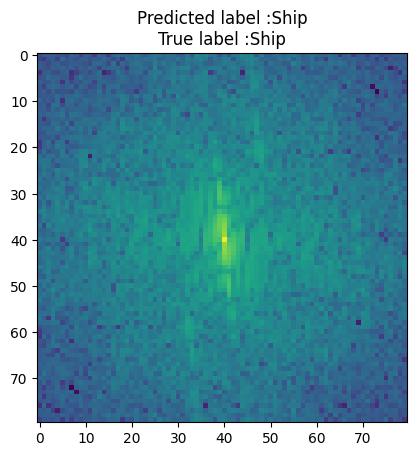

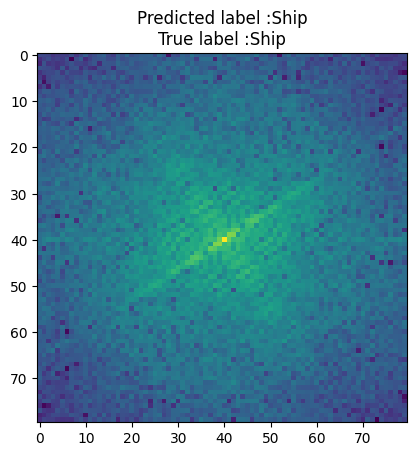

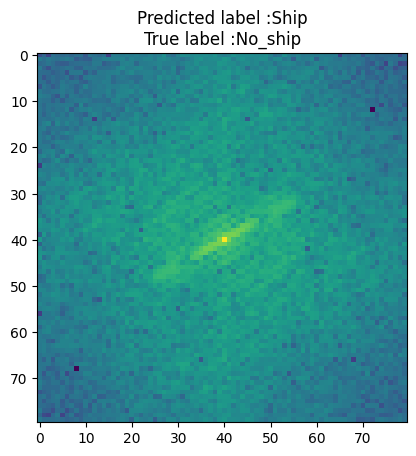

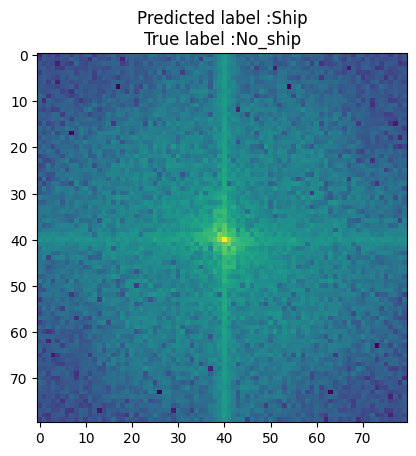

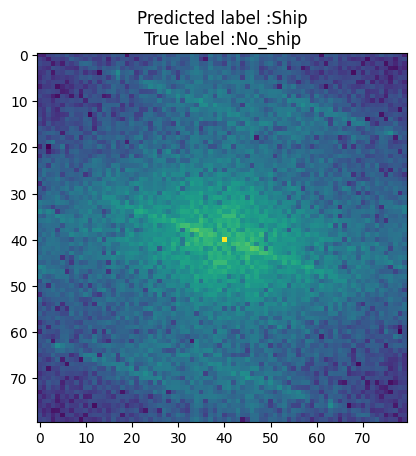

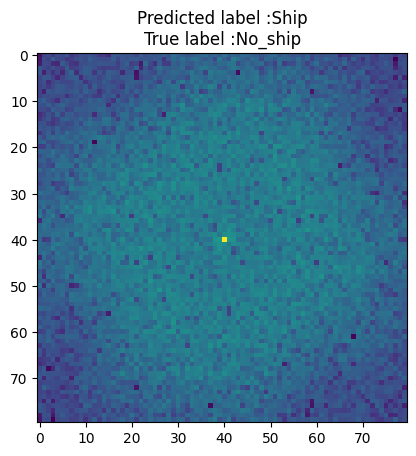

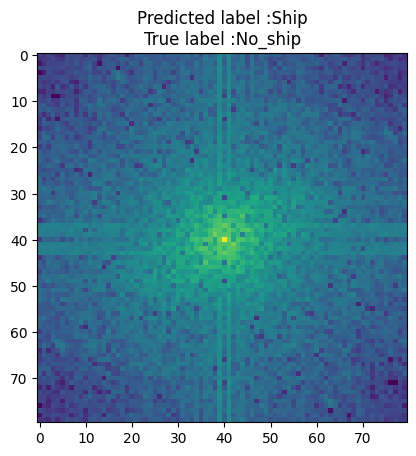

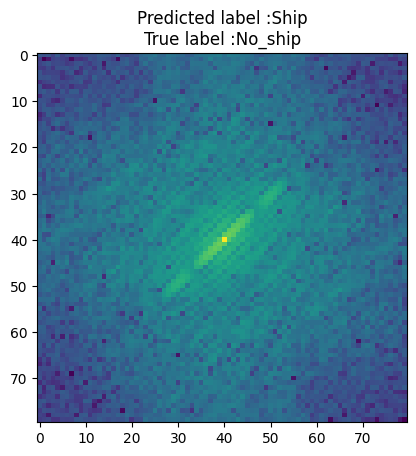

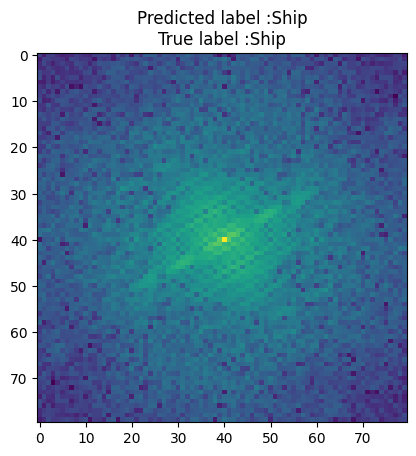

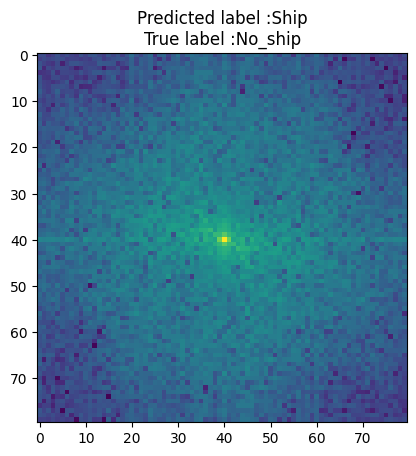

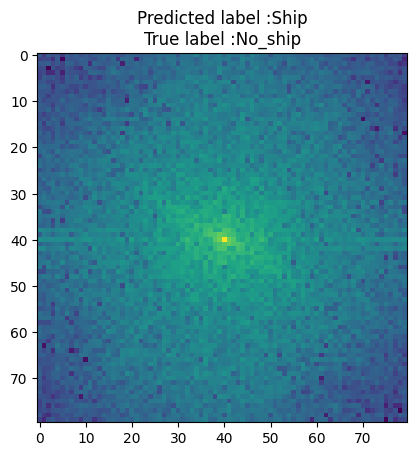

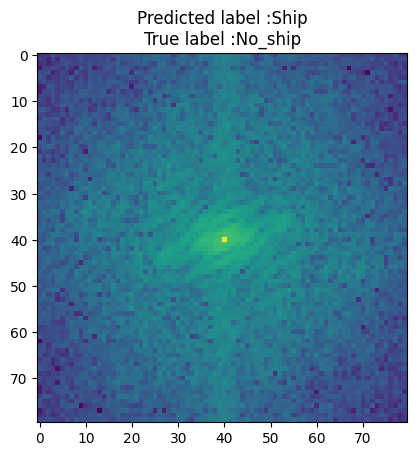

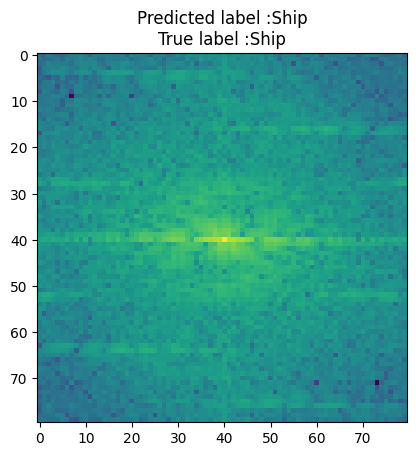

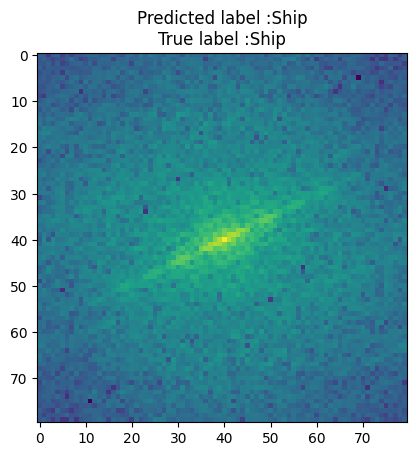

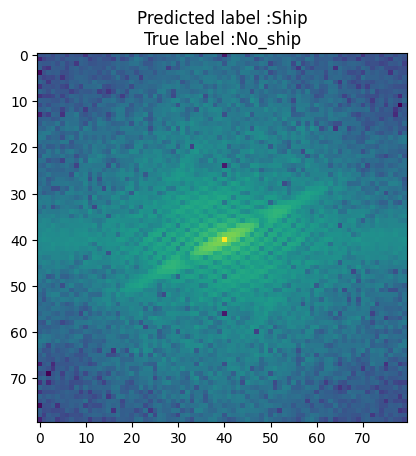

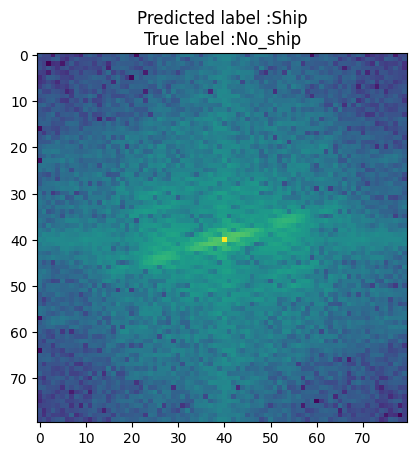

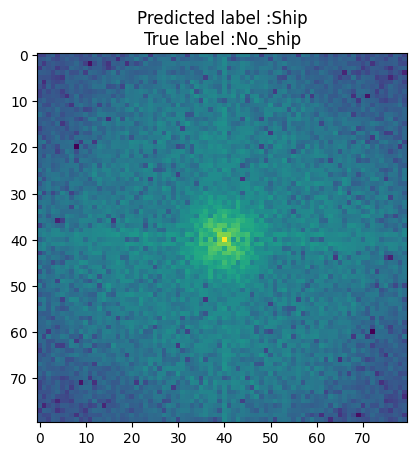

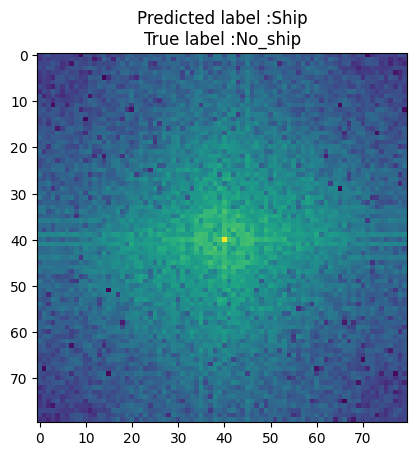

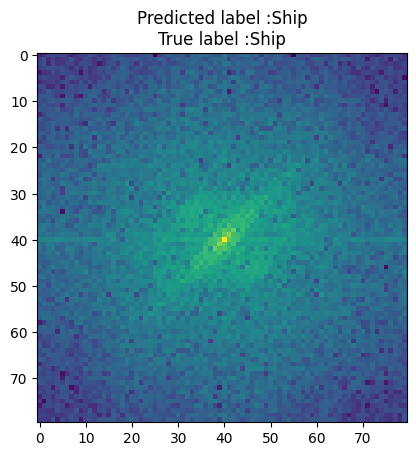

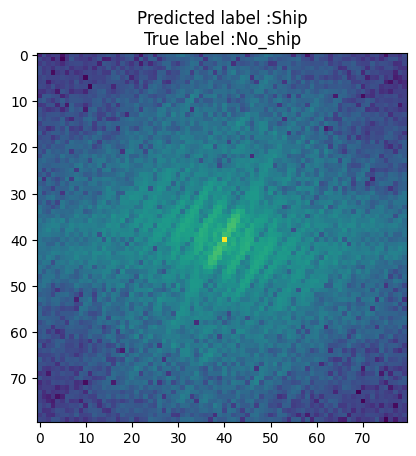

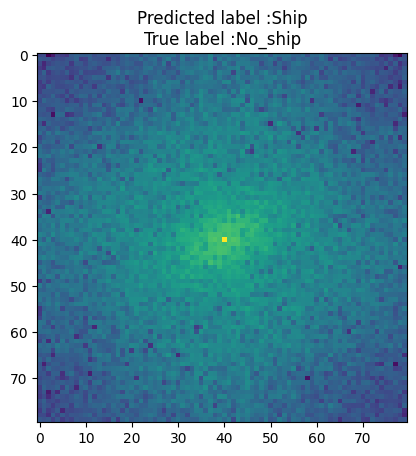

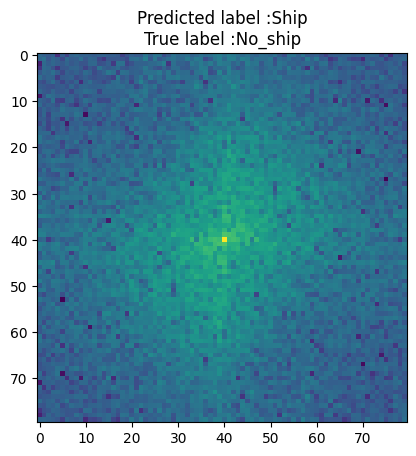

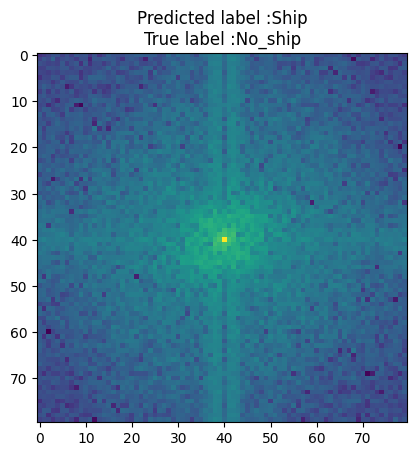

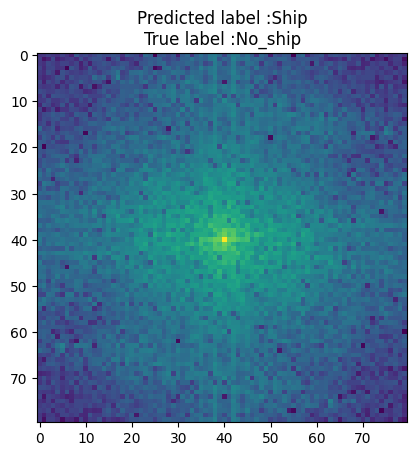

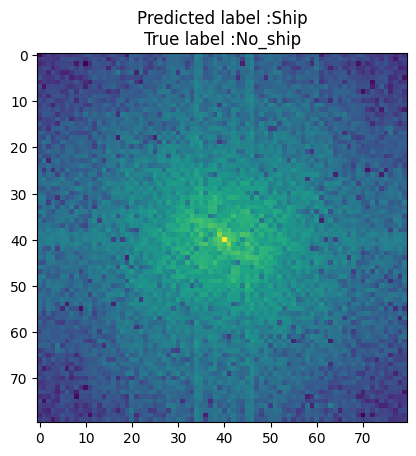

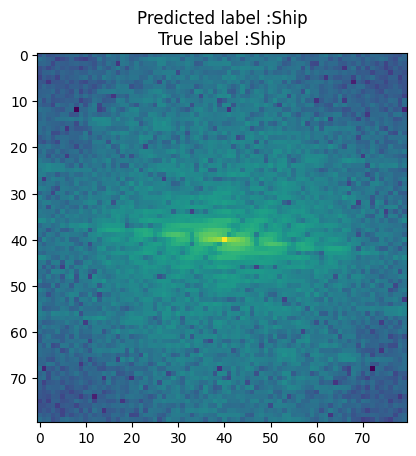

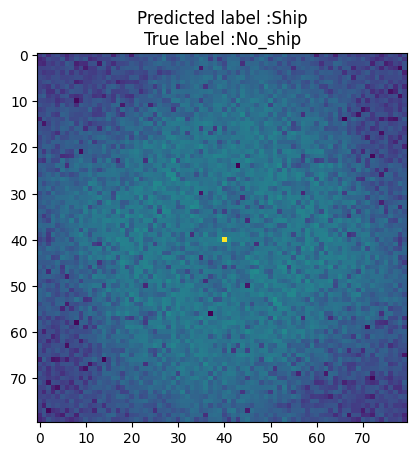

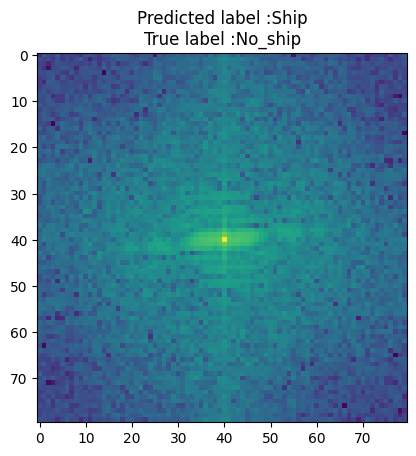

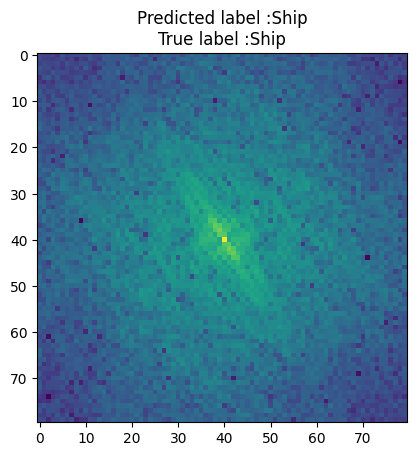

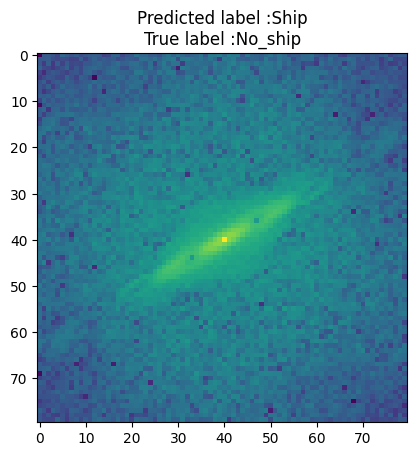

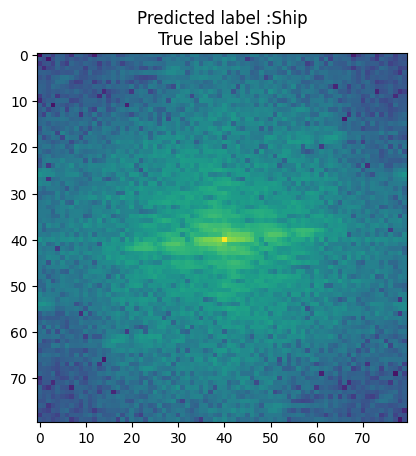

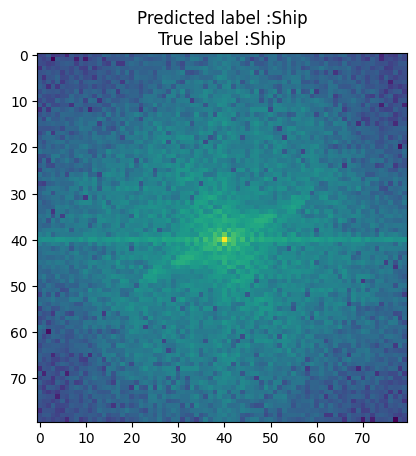

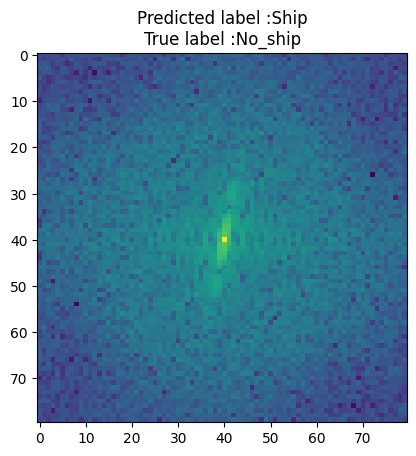

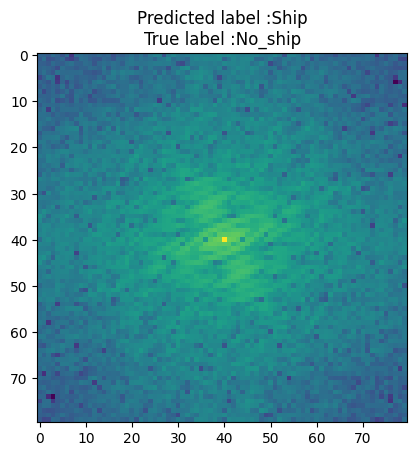

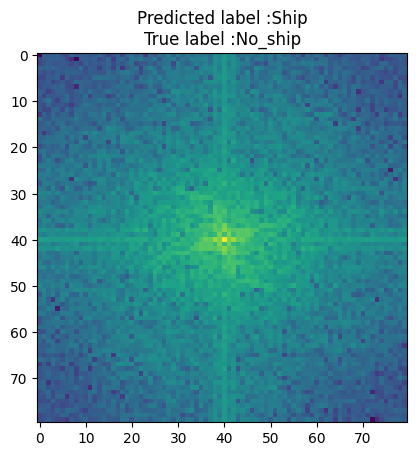

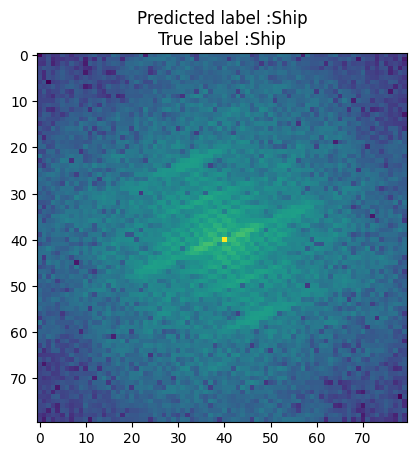

In [60]:
import numpy as np
listed = list(np.where(dataframed))
listed = listed[0].tolist()
listed = list(set(listed))
y1 = Boat_Detection.predict(X_Test)
for x in range(0, 50) :
        plt.subplots()
        plt.imshow(X_Test[x])
        prediction_answer = int(np.round(y1[x]))
        plt.title("Predicted label :{}\nTrue label :{}".format(label_word[prediction_answer], label_word[y_Test.iloc[int(listed[x])]['label']]))